# Curve decoding

Analysis to see if you can decode left vs right turns from individual units in M2.

Start by collecting all data across all units/recorings/curves crossings etc...  this includes outward and inward bouts too. 

In [418]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd


sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths.signals import rolling_mean
from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts, curves, get_roi_crossings

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")

# print all available recordings
print(get_recording_names())

['FC_220408_BAA1101192_hairpin' 'FC_220409_BAA1101192_hairpin'
 'FC_220410_BAA1101192_hairpin' 'FC_220411_BAA1101192_hairpin'
 'FC_220412_BAA1101192_hairpin' 'FC_220413_BAA1101192_hairpin'
 'FC_220414_BAA1101192_hairpin' 'FC_220415_BAA1101192_hairpin'
 'FC_220432_BAA1101192_hairpin' 'FC_220433_BAA1101192_hairpin'
 'FC_220434_BAA1101192_hairpin' 'FC_220435_BAA1101192_hairpin']


In [419]:
def frate(spikes, s, bins):
    """
        Given the s position at each frame at the frame at which spikes occurred during a ROI crossing,
        get firing rate wrt position relative to the apex.
    """
    
    n_visits_per_bin = np.histogram(s, bins=bins)[0]

    spikes_positions = [s[spike] for spike in spikes]
    nspikes_per_bin = np.histogram(spikes_positions, bins=bins)[0]

    spikes_positions = rolling_mean(spikes_positions, 5)
    nspikes_per_bin = rolling_mean(nspikes_per_bin, 5)

    frates = nspikes_per_bin / n_visits_per_bin * 60
    frates[np.isnan(frates)] = 0.0
    frates[np.isinf(frates)] = 0.0  # a spike but no frame count?
    return frates

In [420]:
ds = 2
bins = np.arange(-20, 20+ds, step=ds)


data = {
    **dict(
        name=[],  # recording name
        unit_id=[],  # unit id
        brainregion=[],  # brain region
        direction=[],  # direction (out/in)
        roi = [],  # ROI name
        label=[],  # left, right or straight
    ),
    **{s:[] for s in bins[1:]}  # firing rate at each S position bin
}


In [421]:
curve_direction = dict(
    first=dict(out="right", _in="left"),
    second=dict(out="right", _in="left"),
    third=dict(out="left", _in="right"),
    fourth=dict(out="left", _in="right"),
)


for REC in get_recording_names():
    # fetch recording data
    units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    if units is None:
        continue
    units = units.loc[units.brain_region.isin(["MOs", "MOs1", "MOs2/3", "MOs5", "MOs6a", "MOs6b"])]

    out_bouts = get_session_bouts(REC, complete=None)
    in_bouts = get_session_bouts(REC, direction="inbound", complete=None)
    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}


    for (i, unit) in units.iterrows():
        for curve in ("second", "third", "fourth"):
            for (direction, crossings, bouts) in (("out", out_crossings[curve], out_bouts), ("_in", in_crossings[curve], in_bouts)):
                sign = 1 if direction == "out" else -1

                for i, cross in crossings.iterrows():

                    # get spikes at each bin
                    bout = bouts.iloc[cross.bout_idx]
                    s = sign * (curves[curve].s - np.array(bout.s[cross.enter_frame:cross.exit_frame]))
                    spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame

                    # get firing rate
                    cross_frate = frate(spikes, s, bins)

                    # store all data
                    data["name"].append(REC)
                    data["unit_id"].append(unit.unit_id)
                    data["brainregion"].append(unit.brain_region)
                    data["direction"].append(direction)
                    data["roi"].append(curve)
                    data["label"].append(curve_direction[curve][direction])
                    for i, bin in enumerate(bins[1:]):
                        data[bin].append(cross_frate[i])


data = pd.DataFrame(data)
data.head()

,name,unit_id,brainregion,direction,roi,label,-18,-16,-14,-12,...,2,4,6,8,10,12,14,16,18,20
0,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,10.000000,10.0,12.0,8.0,...,12.000000,12.0,9.0,20.0,16.0,12.0,16.0,16.000000,7.5,13.333333
1,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,6.666667,7.5,6.0,2.4,...,0.000000,0.0,0.0,0.0,0.0,3.0,3.0,3.000000,5.0,10.000000
2,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,20.000000,5.0,3.0,12.0,...,9.000000,8.0,6.0,8.0,8.0,4.0,4.0,4.000000,0.0,0.000000
3,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,0.000000,0.0,0.0,3.0,...,8.000000,9.0,4.8,7.2,4.0,6.0,6.0,8.000000,3.0,3.333333
4,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,10.000000,7.5,12.0,12.0,...,5.333333,9.6,7.2,9.0,4.8,6.0,4.8,1.714286,0.0,0.000000


In [422]:
# label each row by the unit/recording it belongs to
data["identifier"] = data["name"] + data["unit_id"].astype(str)
n_units = len(data.identifier.unique())
print(n_units)

475


## Fit model
For each unit, try to predict L/R turn from the firing rate of the unit.

In [423]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from fcutils.progress import track
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [424]:
# create dummy variables columns
data = data.join(pd.get_dummies(data[["label", "direction"]]))
data.head()

,name,unit_id,brainregion,direction,roi,label,-18,-16,-14,-12,...,12,14,16,18,20,identifier,label_left,label_right,direction__in,direction_out
0,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,10.000000,10.0,12.0,8.0,...,12.0,16.0,16.000000,7.5,13.333333,FC_220408_BAA1101192_hairpin302,0,1,0,1
1,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,6.666667,7.5,6.0,2.4,...,3.0,3.0,3.000000,5.0,10.000000,FC_220408_BAA1101192_hairpin302,0,1,0,1
2,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,20.000000,5.0,3.0,12.0,...,4.0,4.0,4.000000,0.0,0.000000,FC_220408_BAA1101192_hairpin302,0,1,0,1
3,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,0.000000,0.0,0.0,3.0,...,6.0,6.0,8.000000,3.0,3.333333,FC_220408_BAA1101192_hairpin302,0,1,0,1
4,FC_220408_BAA1101192_hairpin,302,MOs5,out,second,right,10.000000,7.5,12.0,12.0,...,6.0,4.8,1.714286,0.0,0.000000,FC_220408_BAA1101192_hairpin302,0,1,0,1


In [425]:
PREDICTED = "label_right"

select_cols = list(bins[1:]) + [PREDICTED]

results, shuffled_accuracies = {}, []

for unit in track(data.identifier.unique()):
    # sample L/R trials to get equal number of trials per direction
    unit_data = data.loc[data.identifier == unit]
    # unit_data = unit_data.loc[unit_data.roi == "second"]
    name = unit_data.name.iloc[0]

    side_counts = unit_data.groupby(["label"])["name"].count()

    n_selected = min(side_counts["left"], side_counts["right"])
    if n_selected < 10:
        continue
    left = unit_data.loc[unit_data.label == "left"].sample(n_selected)
    right = unit_data.loc[unit_data.label == "right"].sample(n_selected)

    # keep bins + label column
    unit_data = pd.concat([left, right])[select_cols]

    # split train/test
    X = unit_data.drop(PREDICTED, axis=1)
    y = unit_data[PREDICTED]

    # skip units with no spikes
    if np.max(X.mean().values) < .5:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # scale data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

    # fit model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    accuracy = logreg.score(X_test, y_test)


    # fit model on randomly shuffled labels
    for i in range(3):
        y_shuffled = y.sample(frac=1, random_state=i)
        _, _, y_shuff_train, y_shuff_test = train_test_split(X, y_shuffled, test_size=0.3, random_state=0)

        shuffled_logreg = LogisticRegression()
        shuffled_logreg.fit(X_train, y_shuff_train)

        shuffled_accuracies.append(shuffled_logreg.score(X_test, y_shuff_test))

    
    # fit model with statsmodels
    try:
        logit_model=sm.Logit(y_train, X_train, missing="raise")
        result=logit_model.fit_regularized (maxiter=1000)
    except:
        continue


    results[unit] = dict(
        name=name,
        identifier=unit,
        model=logreg,
        sm_model = result,
        accuracy=accuracy,
        scaler=scaler,
        X_test=X_test,
        y_test=y_test,

    )

    # if len(results.keys()) > 100:
    #     break

print(f"Succesfully fit {len(results.keys())} models for {n_units}")

Working... ━━━ Completed:  Completed 475/475 100% • Speed:  3… • Remaining:  re… Elpsed:  el…
                                                            s…               0:…          0:…

Succesfully fit 451 models for 475


# Plot results
plot accuracy histograma and ROC curve

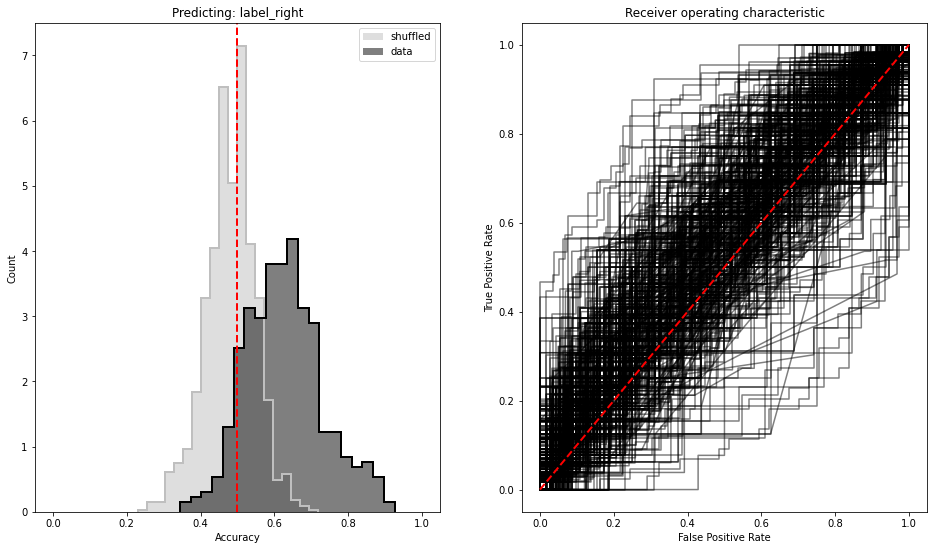

In [426]:
f, axes = plt.subplots(1, 2, figsize=(16, 9))

accuracies = [r["accuracy"] for r in results.values()]

axes[0].hist(shuffled_accuracies, density=True, bins=20, alpha=.5, color=[.75, .75, .75], label="shuffled")
axes[0].hist(shuffled_accuracies, density=True, bins=20, lw=2, histtype="step", color=[.75, .75, .75])
axes[0].hist(accuracies, density=True, bins=20, alpha=.5, color="k", label="data")
axes[0].hist(accuracies, density=True, bins=20, lw=2, histtype="step", color="k")
axes[0].legend()

for res in results.values():
    logit_roc_auc = roc_auc_score(res['y_test'], logreg.predict(res['X_test']))
    fpr, tpr, thresholds = roc_curve(res['y_test'], logreg.predict_proba(res['X_test'])[:,1])

    axes[1].plot(fpr, tpr, color="k", alpha=.5)

axes[0].set(xlabel="Accuracy", ylabel="Count", title=f"Predicting: {PREDICTED}", xlim=[-0.05, 1.05])
axes[0].axvline(0.5, lw=2, color="r", ls="--")
axes[1].plot([0, 1], [0, 1],'r--', lw=2)
_ = axes[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver operating characteristic')

In [427]:
accuracies = np.array(accuracies)
above_66 = len(accuracies[accuracies >= 0.6])
above_90 = len(accuracies[accuracies >= 0.9])
print(f"{above_66}/{len(accuracies)} ({round(above_66/len(accuracies) * 100, 2)}%) units have accuracy > 60%")
print(f"{above_90}/{len(accuracies)} ({round(above_90/len(accuracies) * 100, 2)}%) units have accuracy > 90%")

271/451 (60.09%) units have accuracy > 60%
2/451 (0.44%) units have accuracy > 90%


In [428]:
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from pylab import cm
from sklearn.preprocessing import minmax_scale


In [429]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)
    return cbar


In [430]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Trying to register the cmap 'shifted' which already exists.


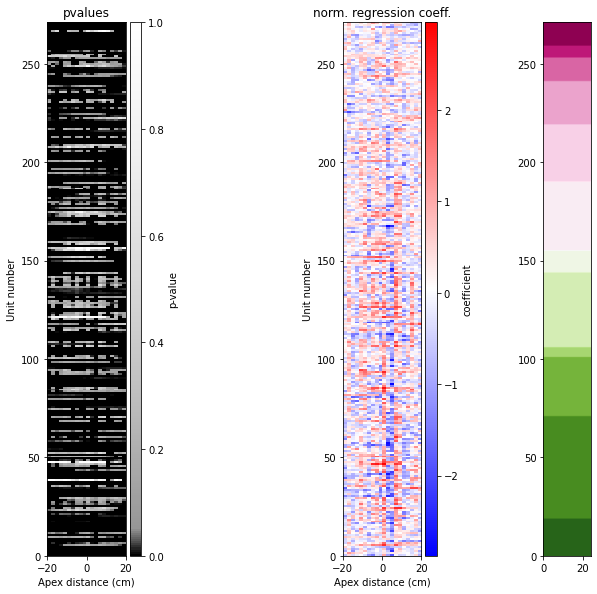

In [433]:
import matplotlib

# plot pvalues of each accurate model model
pvals, coeffs, identifiers, sessions = [], [], [], []
for res in results.values():
    if res["accuracy"] < 0.6:
        continue

    pvals.append(res["sm_model"].params)
    coeffs.append((res["model"].coef_))
    identifiers.append(res["identifier"])
    sessions.append(res["name"])
    
N = len(pvals)


sorter = np.argsort(sessions)
# sorter = np.argsort([np.argmax(np.abs(p)) for p in coeffs])
ids = LabelEncoder().fit_transform(sessions)[sorter].reshape(-1, 1)

# pvals = np.vstack([zscore(p) for p in pvals])[sorter]
# pvals = zscore(np.vstack(pvals), axis=1)[sorter]
pvals = np.vstack(pvals)[sorter]
_coeffs = np.vstack(coeffs)[sorter]


fig = plt.figure(figsize=(10, 8))
axes = fig.subplot_mosaic(
"""
    AAACCB
    AAACCB
"""
)
fig.tight_layout()

shifted_cmap = shiftedColorMap(matplotlib.cm.Greys_r, midpoint=0.05, name='shifted')

I = axes['A'].imshow(pvals, extent=[-20, 20, 0, N], interpolation="none", cmap=shifted_cmap, vmin=0, vmax=1)
add_colorbar(axes['A'], I, "p-value")
I = axes['C'].imshow(_coeffs, extent=[-20, 20, 0, N], interpolation="none", cmap="bwr",)
add_colorbar(axes['C'], I, "coefficient")

cmap = cm.get_cmap('PiYG', len(ids)) 
axes['B'].imshow(ids, extent=[0, 24, 0, N], cmap=cmap)
_ = axes['A'].set(xlabel="Apex distance (cm)", ylabel="Unit number", title="pvalues")

_ = axes['C'].set(xlabel="Apex distance (cm)", ylabel="Unit number", title="norm. regression coeff.")


In [432]:
# plot a histogram for the distribution of values of each regression bin
bins
len(pval[0])

NameError: name 'pval' is not defined

## Plot activity heatmap

Plt activity heatmap of each unit as avg firing rate over space aligned to the curve apex

In [ ]:
select_cols = list(bins[2:])
good_units = [r["identifier"] for r in results.values() if r["accuracy"] > 0.6]

# get average firing rate for each unit for L/R turns but split in half to fit hetmap sorting
fit_res = dict(left=[], right=[])
plot_res = dict(left=[], right=[])


for unit in good_units:
    unit_data = data.loc[data.identifier == unit]

    if unit_data.shape[0] == 0:
        continue

    if np.mean(unit_data[select_cols].mean().values) < 1:
        continue

    # split between left/right
    left_data = unit_data.loc[unit_data.label == "left"]
    right_data = unit_data.loc[unit_data.label == "right"]

    # split each in half for fitting shuffling
    left_train, left_test, _, _ = train_test_split(left_data, left_data["label"], test_size=0.5, random_state=0)
    right_train, right_test, _, _ = train_test_split(right_data, right_data["label"], test_size=0.5, random_state=0)


    fit_res['left'].append(left_train[select_cols].mean().values)
    fit_res['right'].append(right_train[select_cols].mean().values)
    plot_res['left'].append(left_test[select_cols].mean().values)
    plot_res['right'].append(right_test[select_cols].mean().values)

    # if len(plot_res['left']) > 100:
    #     break
    

In [ ]:
def get_sorting(x):
    x = [zscore(p) for p in x]
    largest = np.array([max(y.min(), y.max(), key=abs) for i, y in enumerate(x)])
    positive_selector = np.argwhere(largest >= 0).ravel()
    negative_selector = np.argwhere(largest < 0).ravel()

    # split x between positive and negative
    x_pos = np.array(x)[positive_selector]
    x_neg = np.array(x)[negative_selector]

    # sort each half
    pos_sorter = np.argsort([np.argmax(p) for p in x_pos])
    neg_sorter = np.argsort([np.argmin(p) for p in x_neg])

    return positive_selector, negative_selector, pos_sorter, neg_sorter




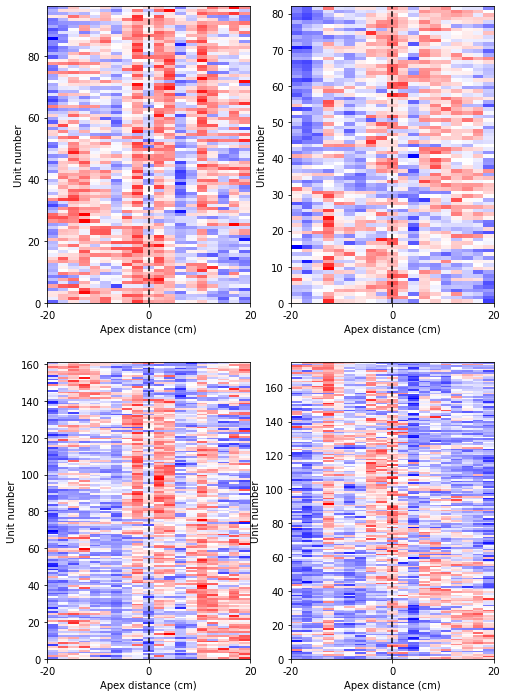

In [ ]:
positive_selector, negative_selector, pos_sorter, neg_sorter = get_sorting(fit_res['left'])

left_pos = np.array(plot_res['left'])[positive_selector][pos_sorter]
left_neg = np.array(plot_res['left'])[negative_selector][neg_sorter]
left_pos = zscore(left_pos, axis=1)
left_neg = zscore(left_neg, axis=1)


positive_selector, negative_selector, pos_sorter, neg_sorter = get_sorting(fit_res['right'])

right_pos = np.array(plot_res['right'])[positive_selector][pos_sorter]
right_neg = np.array(plot_res['right'])[negative_selector][neg_sorter]
right_pos = zscore(right_pos, axis=1)
right_neg = zscore(right_neg, axis=1)



f, axes = plt.subplots(2, 2, figsize=(8, 12))
axes[0, 0].imshow(left_neg, extent=[-40, 40, 0, left_neg.shape[0]], aspect="auto", cmap="bwr", interpolation="none")
axes[1, 0].imshow(left_pos, extent=[-40, 40, 0, left_pos.shape[0]], aspect="auto", cmap="bwr", interpolation="none")
axes[0, 1].imshow(right_neg, extent=[-40, 40, 0, right_neg.shape[0]], aspect="auto", cmap="bwr", interpolation="none")
axes[1, 1].imshow(right_pos, extent=[-40, 40, 0, right_pos.shape[0]], aspect="auto", cmap="bwr", interpolation="none")

for ax in axes.flatten():
    ax.set(xticks=[-40, 0, 40], xticklabels=["-20", "0", "20"], ylabel="Unit number", xlabel="Apex distance (cm)")
    ax.axvline(0, color="k", linestyle="--")

[<matplotlib.lines.Line2D object at 0x0000028949FE1048>]

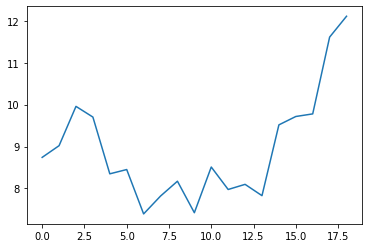

In [ ]:
plt.plot(l[1])

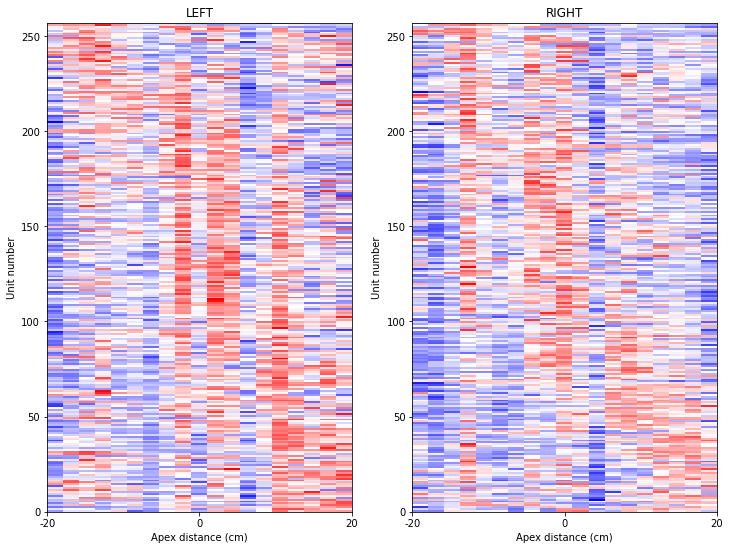

In [ ]:
from sklearn.preprocessing import scale

l = fit_res['left']
largest = np.array([np.argmax(np.abs(y)) for y in l])
sort = np.argsort(largest)
in_order = [scale(plot_res['left'][i]) for i in sort]
L = np.vstack(in_order)

r = fit_res['right']
largest = np.array([np.argmax(y) for y in r])
sort = np.argsort(largest)
in_order = [scale(plot_res['right'][i]) for i in sort]
R = np.vstack(in_order)

f, axes = plt.subplots(figsize=(12, 9), ncols=2)
axes[0].imshow(L, extent=[-40, 40, 0, L.shape[0]], aspect="auto", cmap="bwr", interpolation="none")
axes[1].imshow(R, extent=[-40, 40, 0, R.shape[0]], aspect="auto", cmap="bwr", interpolation="none")

axes[0].set(xticks=[-40, 0, 40], xticklabels=["-20", "0", "20"], ylabel="Unit number", xlabel="Apex distance (cm)", title="LEFT")
_ = axes[1].set(xticks=[-40, 0, 40], xticklabels=["-20", "0", "20"], ylabel="Unit number", xlabel="Apex distance (cm)", title="RIGHT")
